In [1]:

import os
# If this notebook lives in /notebooks/, move to project root:
os.chdir("..")

# Core ML imports
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks

# Data loading helper
from data_utils import get_datasets

# Evaluation & plotting
import numpy as np
import matplotlib.pyplot as plt



# Load datasets once for the entire notebook
train_ds, val_ds = get_datasets()
print("✔️ Datasets ready — Train batches:", 
      tf.data.experimental.cardinality(train_ds).numpy(),
      "Val batches:", tf.data.experimental.cardinality(val_ds).numpy())



Found 791 files belonging to 2 classes.
Using 633 files for training.
Found 791 files belonging to 2 classes.
Using 158 files for validation.
✔️ Datasets ready — Train batches: 20 Val batches: 5


In [2]:
from tensorflow.keras import layers, models, regularizers, Input

def build_cnn_model(input_shape=(128,128,3)):
    return models.Sequential([
        Input(shape=input_shape),
        layers.Conv2D(32,(3,3),activation='relu'),
        # layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(64,(3,3),activation='relu'),
        # layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Conv2D(128,(3,3),activation='relu'),
        # layers.BatchNormalization(),
        layers.MaxPooling2D(),

        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid'),
    ])

model = build_cnn_model()
model.summary()



Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Compile the model
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss      = 'binary_crossentropy',
    metrics   = ['accuracy']
)

# Early stopping
early_stop = EarlyStopping(
    monitor='accuracy',
    patience=5,
    restore_best_weights=True
)

# Save best model
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_accuracy',
    save_best_only=True
)

# Learning‐rate scheduler: halve LR when val_loss plateaus
lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

print("Callbacks ready: early_stop, checkpoint, lr_scheduler")




Callbacks ready: early_stop, checkpoint, lr_scheduler


In [7]:
EPOCHS = 20

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=20,                  
    callbacks=[early_stop, lr_scheduler],  
    verbose=1                   
)




Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 101ms/step - accuracy: 0.6200 - loss: 0.6515 - val_accuracy: 0.9810 - val_loss: 0.4286 - learning_rate: 1.0000e-04
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 101ms/step - accuracy: 0.6758 - loss: 0.5956 - val_accuracy: 0.9557 - val_loss: 0.3024 - learning_rate: 1.0000e-04
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step - accuracy: 0.7421 - loss: 0.5264 - val_accuracy: 0.9304 - val_loss: 0.2917 - learning_rate: 1.0000e-04
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.7790 - loss: 0.4610 - val_accuracy: 0.9304 - val_loss: 0.2353 - learning_rate: 1.0000e-04
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.8279 - loss: 0.4181 - val_accuracy: 0.9241 - val_loss: 0.2384 - learning_rate: 1.0000e-04
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.8307 - loss: 0.3793
Epoch 6: ReduceLROnPlateau reducing learning rate to 4.999999873689376e-05.
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 98ms/step - accuracy: 0.8315 - l

In [14]:
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# 1) Load the full saved model (arch + weights)
model = load_model('best_model.h5')

# 2) Evaluate on the validation dataset
val_loss, val_acc = model.evaluate(val_ds, verbose=0)
print(f"Final validation accuracy: {val_acc:.4f}, loss: {val_loss:.4f}")

# 3) Get predicted probabilities for all val samples
y_prob = model.predict(val_ds).flatten()
y_pred = (y_prob >= 0.5).astype(int)

# 4) Collect true labels in one go
y_true = np.concatenate([labels.numpy().astype(int) 
                         for _, labels in val_ds], axis=0)

# 5) Confusion matrix and classification report
print("Confusion Matrix:")
print(confusion_matrix(y_true, y_pred))

print("\nClassification Report:")
print(classification_report(
    y_true, 
    y_pred, 
    target_names=['Bike','Car'],
    zero_division=0      # set metrics to 0 when no true samples
))





Final validation accuracy: 0.7152, loss: 0.6857
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Confusion Matrix:
[[  0   0]
 [ 45 113]]

Classification Report:
              precision    recall  f1-score   support

        Bike       0.00      0.00      0.00         0
         Car       1.00      0.72      0.83       158

    accuracy                           0.72       158
   macro avg       0.50      0.36      0.42       158
weighted avg       1.00      0.72      0.83       158



2025-06-09 22:52:01.639153: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


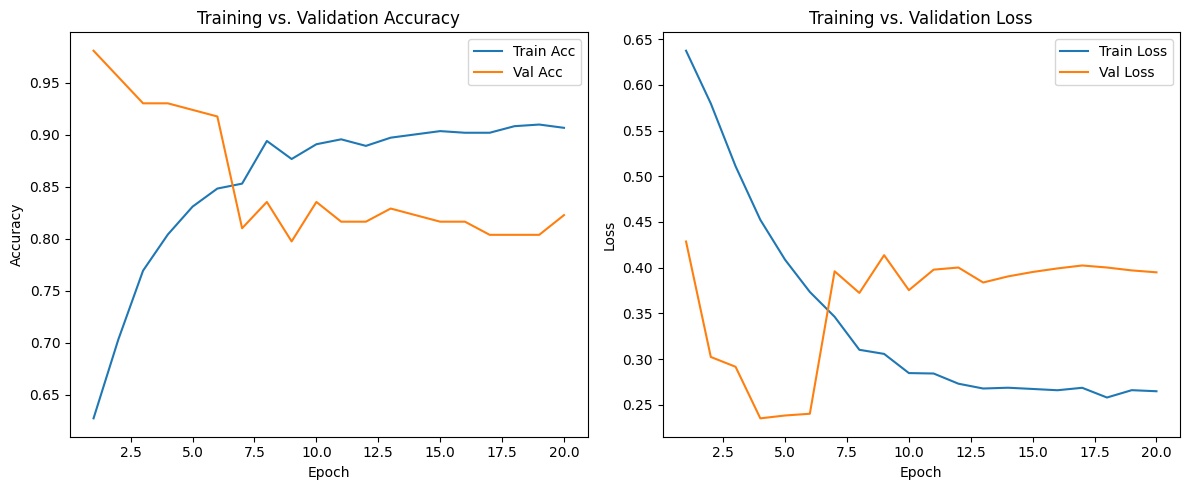

In [9]:
import matplotlib.pyplot as plt

# Pull metrics from history
acc       = history.history['accuracy']
val_acc   = history.history['val_accuracy']
loss_vals = history.history['loss']
val_loss  = history.history['val_loss']
epochs    = range(1, len(acc) + 1)

plt.figure(figsize=(12, 5))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Train Acc')
plt.plot(epochs, val_acc, label='Val Acc')
plt.title('Training vs. Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(epochs, loss_vals, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.title('Training vs. Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



In [10]:
# Gap analysis
train_acc  = history.history['accuracy'][-1]
val_acc    = history.history['val_accuracy'][-1]
train_loss = history.history['loss'][-1]
val_loss   = history.history['val_loss'][-1]

print(f"Final Train Acc:      {train_acc:.4f}")
print(f"Final Validation Acc: {val_acc:.4f}")
print(f"Accuracy Gap:         {train_acc - val_acc:.4f}")
print(f"Final Train Loss:     {train_loss:.4f}")
print(f"Final Validation Loss:{val_loss:.4f}")
print(f"Loss Gap:             {val_loss - train_loss:.4f}")


Final Train Acc:      0.9068
Final Validation Acc: 0.8228
Accuracy Gap:         0.0840
Final Train Loss:     0.2649
Final Validation Loss:0.3950
Loss Gap:             0.1300
